In [1]:
from operator import add
#from astropy import units as u
#from astropy.coordinates import SkyCoord
#from astropy.stats import LombScargle
#from gatspy.periodic import LombScargleFast
from functools import partial
#from gatspy import periodic
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import lomb_scargle_multiband as periodic
from multiprocessing import Pool
import numpy as np
import os
#from sqlite3 import *
import random
from random import shuffle
from random import randint
import Observations
import Magnitudes
import time

In [2]:
# LSST zero points  u,g,r,i,z,y
zeroPoints = [0,26.5,28.3,28.13,27.79,27.4,26.58]
FWHMeff = [0.8,0.92,0.87,0.83,0.80,0.78,0.76] # arcmins?
pixelScale = 0.2
readOut = 12.7
sigSys = 0.005
flareperiod = 1024
flarecycles = 10
dayinsec=86400
background = 40
# sat mag u,g,r,i,z,y=14.7,15.7,15.8,15.8,15.3 and 13.9
# start date 59580.033829 end date + 10 years
#maglist=[20]*7

lim = [0, 23.5, 24.8, 24.4, 23.9, 23.3, 22.1] # limiting magnitude ugry
sat = [0, 14.7, 15.7, 15.8, 15.8, 15.3, 13.9] # sat mag as above


# In[15]:


looooops = 1
maglength = 5
freqlength = 5
processors = 5

startnumber = 0 + 0                  
endnumber = startnumber + 1

#observingStrategy = 'minion'
observingStrategy = 'astroD'
#observingStrategy = 'panstars'



inFile = '/home/mj1e16/periodic/in'+str(startnumber)+'.txt'
outFile = '/home/mj1e16/periodic/outminion630'+str(startnumber)+'.txt'

#inFile = '/home/ubuntu/vagrant/'+observingStrategy+'/in'+observingStrategy+'KtypefullresultsFile'+str(startnumber)+'.txt'
#outFile = '/home/ubuntu/vagrant/'+observingStrategy+'/out'+observingStrategy+'KtypefullresultsFile'+str(startnumber)+'.txt'


#obs = Observations.obsastro630
obs = np.linspace(59630.320217,59630.320217+(365.25*10),100000)
obs = obs.tolist()
obs = [obs]*7
# for y in range(len(obs)):
#     obs[y] = [x + random.random() for x in obs[y]]

#In[19]:

In [3]:
random.random()

0.6984225929017523

In [4]:
def lc_sim(nn, delt, mean_lc, model, params):

    '''
    Python function to simulate a light curve given a model power spectrum
    Based on paper Timmer, J., & Koenig, M. 1995, A&A, 300, 707
    nn = number of points in simulated light curve
    delt = time sampling of simulated light curve in seconds
    mean_lc = mean value of simulated light curve
    model = "unbroken", "sharp", or "slow" to designate what type of power spectrum the simulated
             light curve will be based on
    params = 4 (for 'unbroken' model) or 5 (for the other two) element array containing the
             parameters of the power spectrum model
             For 'unbroken', S = N*(nu/nu_0)**(-beta) + noise:
             params[0] = N, normalization of power spectrum
             params[1] = nu_0, the frequency at which the power = the normalization
             params[2] = beta, the slope of the power spectrum
             params[3] = white noise level to add in
             For 'sharp', S = N*(nu/nu_c)^(-gamma) + noise      nu < nu_c
                          S = N*(nu/nu_c)^(-beta)  + noise      nu > nu_c
                params[0] = N, normalization of power spectrum
                params[1] = nu_c, the pivot frequency
                params[2] = gamma, the low frequency slope
                params[3] = beta, the high frequency slope
                params[4] = white noise level
            For 'slow', S = N*nu^(alpha_lo)/(1+(nu/nu_k))^(alpha_hi - alpha_lo)
            params[0] = N, normalization of power spectrum
            params[1] = nu_k, the 'knee' frequency where the spectrum rolls over
            params[2] = alpha_lo, the low frequency slope
            params[3] = alpha_high, the high frequency slope
            params[4] = white noise level
    '''

    import numpy as np

    #Seed the random number generator
    #np.random.seed(6543289)

    #Fourier frequencies
    fi = np.arange(1, nn/2+1, dtype='float64')/nn/delt
    #print fi

    '''
    Power at each frequency depending on power spectrum model
    Unbroken model: S = N*(nu/nu0)^(-beta)
    Sharply broken model: S = N*(nu/nu_c)^(-gamma)       nu < nu_c
                          S = N*(nu/nu_c)^(-beta)        nu > nu_c
    Slowly bending "knee" model: S = N*nu^(alpha_low)/(1+(nu/nu_k))^(alpha_hi - alpha_lo)
    '''
    if model == 'unbroken':

        a = params[0]
        nu_0 = params[1]
        beta = params[2]
        noise = params[3]

        s = a*(fi/nu_0)**(-beta) + noise

    elif model == 'sharp':

        a = params[0]
        nu_c = params[1]
        gamma = params[2]
        beta = params[3]
        noise = params[4]

        s = np.zeros(len(fi))
        s[fi <= nu_c] = a*(fi[fi <= nu_c]/nu_c)**(-gamma) + noise
        s[fi > nu_c] = a*(fi[fi > nu_c]/nu_c)**(-beta) + noise

    elif model == 'slow':

        a = params[0]
        nu_knee = params[1]
        alpha_lo = params[2]
        alpha_hi = params[3]
        noise = params[4]

        s = (a*fi**(alpha_lo))/(1+(fi/nu_knee))**(alpha_hi - alpha_lo) + noise

    #Generate two sets of normally distributed random numbers 
    aa = np.random.randn(len(fi))
    bb = np.random.randn(len(fi))

    #Fourier transform of light curve  = SQRT(S/2) * (A + B*i)
    flc = np.sqrt(.5*s)*(aa + bb*1.j)
    #plt.plot(np.real(flc))

    if np.mod(nn, 2) == 0:
        flc[-1] = np.sqrt(.5*s[-1])*1

    del aa, bb, s

    #Put the mean of the light curve at frequency = 0
    flc = np.hstack([mean_lc, flc])

    #Take the inverse fourier transform to generate synthetic light curve
    lc = np.fft.irfft(flc, n=nn)

    return lc

In [5]:
def magUncertainy(Filter, objectmag, exposuretime,background, FWHM): # b is background counts per pixel   
    countsPS = 10**((Filter-objectmag)/2.5)
    counts = countsPS * exposuretime
    uncertainty = 1/(counts/((counts/2.3)+(((background/2.3)+(12.7**2))*2.266*((FWHM/0.2)**2)))**0.5) # gain assumed to be 1
    return uncertainty
#from lsst should have got the website! https://smtn-002.lsst.io/


def averageFlux(observations, Frequency, exptime):
    b = [0]*len(observations)
    for seconds in range(0, exptime):
        a = [np.sin((2*np.pi*(Frequency))*(x+(seconds/(3600*24)))) for x in observations] # optical modulation
        b = map(add, a, b)
    c = [z/exptime for z in b]
    return c

def Flux(observations,Frequency,exptime):
    a = [np.sin((2*np.pi*(Frequency)*x)) for x in observations]
    return a


def ellipsoidalFlux(observations, Frequency,exptime):
    period = 1/(Frequency)
    #print(period)
    phase = [(x % (2*period)) for x in observations]
    b = [0]*len(observations)
    for seconds in range(0, exptime):
        a = [np.sin((2*np.pi*(Frequency))*(x+(seconds/(3600*24)))) for x in observations] # optical modulation
        b = map(add, a, b)
    c = [z/exptime for z in b]
    
    for x in range(0,len(phase)):
        if (phase[x]+(1.5*period)) < (3*period):
            c[x] = c[x]*(1./3.)
        else:
            c[x] = c[x]*(2./3.)
    return c


def flaring(B, dayinsec=86400,amplitude=1):   
    #global flareMag, minutes
    fouriers = np.linspace(0.00001,0.05,(dayinsec/1))
    logF = [np.log(x) for x in fouriers] # start at 30 go to a day in 30 sec increments
    real = [random.gauss(0,1)*((1/x)**(B/2)) for x in fouriers] #random.gauss(mu,sigma) to change for values from zurita
    # imaginary = [random.gauss(0,1)*((1/x)**(B/2)) for x in fouriers]
#     Neg = [-1*(np.conj(x)) for x in real]
#     Neg.extend(real)
#     real = Neg
    IFT = np.fft.ifft(real)   
    print(len(IFT))
    seconds = np.linspace(0,dayinsec, (dayinsec/1)) # the day in 30 sec increments
    minutes = [x for x in seconds]
    minimum = (np.max(-IFT))
    positive = [x + minimum for x in IFT] # what did this even achieve? it helped with normalisation!
    normalised = [x/(np.mean(positive)) for x in positive] # find normalisation
    normalisedmin = minimum/(np.mean(positive))
    normalised = [x - normalisedmin for x in normalised]
    flareMag = [amplitude * x for x in normalised] # normalise to amplitude
    logmins = [np.log(d) for d in minutes] # for plotting?
    doubleMinutes = np.linspace(0,minutes[-1]*2,len(flareMag))
    plt.plot(minutes,flareMag)
    plt.title('lightcurve')
    plt.savefig(str(dayinsec)+'.png')
    plt.show()
    return flareMag


7.136219888205556


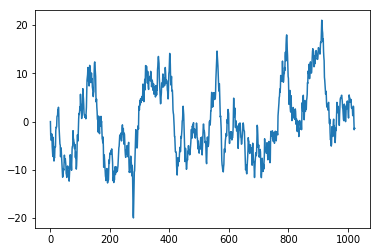

In [6]:
longflare = lc_sim(1024,1,0.,'unbroken',[1.0, 8., 2.0, -1.])
longflare = np.asarray(longflare)
#longflare = longflare[longflare > 0.]
#STD = np.std(longflare)
#longflare = 0.1*(longflare/STD)
#longflare = [x for x in longflare if x > 0.]
print(np.std(longflare))
plt.plot(longflare)
plt.show()

0.01563457150553019
0.1


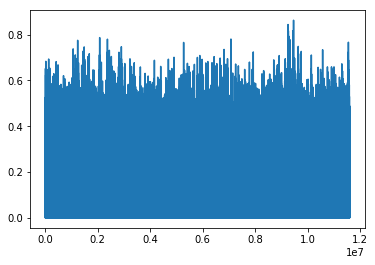

In [7]:
longflare = lc_sim(2880*366*11,30,0.,'unbroken',[1.0, 8., 1.0, -1.])
longflare = np.asarray(longflare)
# longflare = longflare[longflare > 0.]
longflare = np.abs(longflare)
STD = np.std(longflare)
longflare = 0.1*(longflare/STD)
#longflare = [x for x in longflare if x > 0.]
print(STD)
print(np.std(longflare))
plt.plot(longflare)
plt.show()

0.13367141747377825
0.11374691893605182


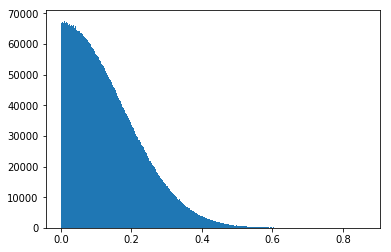

In [8]:
print(np.mean(longflare))
print(np.median(longflare))
number,bins,patches = plt.hist(longflare,bins='auto')
plt.show()
#plt.hist(longflare)

In [9]:
def plotPowerSpectrum(model,freqs,power,frequencyRange,period):
    
    LSperiod = model.best_period
    fig, ax = plt.subplots()
    ax.plot(freqs, power)
    ax.plot((1/LSperiod),0.01,'ro')
    ax.set(yscale='log',
           xscale='log',
           xlabel='Frequency',
           ylabel='Lomb-Scargle Power',
          title='Frequency = '+str(frequencyRange)+', MeasuredFrequency = '+str(1/LSperiod));
    #plt.savefig('rMagPeriod.png')
    plt.show()

#     fig, ax = plt.subplots()
#     ax.plot((1/freqs), power)
#     ax.plot((LSperiod),0.1,'ro')
#     ax.plot(period,0.15,'bo')
#     ax.set(yscale='log',
#            xscale='log',
#            xlabel='Period',
#            ylabel='Lomb-Scargle Power',
#           title='Period = '+str(period)+', MeasuredPeriod = '+str(LSperiod));
#     #plt.savefig('rMag'+str(objectmag[3])+'Period'+str(period)+graphtitle+'.png')
#     plt.show()
    
    print('actual',period,'measured',model.best_period)
    print( model.optimizer.period_range)

In [15]:
def lombScargle(frequencyRange,graphtitle='Oops',longflare=longflare,objectmag=20,loopNo=looooops,numsteps=10000): # frequency range and object mag in list

    results = {}
    totperiod,totmperiod,totpower,SigLevel = [],[],[],[] # resetSigLevel = []
    filterletter = ['o','u','g','r','i','z','y']
    
    period = 1/(frequencyRange) 
    
    fmin=0.5*frequencyRange#0.005
    fmax=2*frequencyRange#400
    
    df = (fmax-fmin)/numsteps
    modulationAmplitude=0.1
    
    
    
    
    measuredpower = [] # reset
    y = [[], [], [], [], [], [], []] # for looping only
    for z in range(1, len(y)):
        y[z] = ellipsoidalFlux(obs[z], frequencyRange,30)
        y[z] = [modulationAmplitude * t for t in y[z]] # scaling
        for G in range(0, len(y[z])):
            flareMinute = int(round(((obs[z][G]-obs[0][0])*24*60*2)))
            y[z][G] = y[z][G] + longflare[flareMinute] # add flares swapped to second but not changing the name intrtoduces fewer bugs

    date,amplitude,mag,error,filts = [],[],[],[],[]
    for z in range(1, len(y)):
        if objectmag[z] > sat[z] and objectmag[z] < lim[z]:
            if z == 3:
                dater = obs[z]
                magr = [objectmag[z] - t for t in amplitude]
            #date.extend([x for x in obs[z]])
            date.extend(obs[z])
            amplitude = [t + random.gauss(0,magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])) for t in y[z]] # scale amplitude and add poisson noise
            mag.extend([objectmag[z] - t for t in amplitude]) # add actual mag
            error.extend([sigSys + magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])+0.2]*len(amplitude))
            filts.extend([filterletter[z]]*len(amplitude))

            phase = [(day % (period*2))/(period*2) for day in obs[z]]
            pmag = [objectmag[z] - t for t in amplitude]
#         plt.plot(phase, pmag, 'o', markersize=4)
#         plt.xlabel('Phase')
#         plt.ylabel('Magnitude')
#         plt.gca().invert_yaxis()
#         plt.title('filter'+str(z)+', Period = '+str(period))#+', MeasuredPeriod = '+str(LSperiod)+', Periodx20 = '+(str(period*20)))
#         plt.show()

#     plt.plot(date, mag, 'o')
# #     lower = date[30]
# #     higher = date[30]+(5*period)
# #     plt.xlim(lower,higher)
#     plt.xlabel('time (days)')
#     plt.ylabel('mag')
#     plt.gca().invert_yaxis()
#     plt.show()
    #baseline = 110
    #baseline = date[-1]-date[0]
    model = periodic.LombScargleMultibandFast(fit_period=True)
    #model.optimizer.period_range=(0.012, 120)
    model.optimizer.period_range=(0.5*period, 2*period)
    model.fit(date, mag, error, filts)
    
    LSperiod = model.best_period
    #print(model.best_scores)
    print(LSperiod)
    
    freqs = fmin + df * np.arange(numsteps) 
    power = model.score_frequency_grid(fmin, df, numsteps) 
    plotPowerSpectrum(model,freqs,power,frequencyRange,period)
    
#     freqs = np.logspace(np.log10(fmin),np.log10(fmax),numsteps)
#     power = model.score_frequency_grid(fmin, df, numsteps) 
#     plotPowerSpectrum(model,freqs,power,frequencyRange,period)

    phase = [(day % (period*2))/(period*2) for day in date]
    #idealphase = [(day % (period*2))/(period*2) for day in dayZ]
    #print(len(phase),len(idealphase))
    #plt.plot(idealphase,Zmag,'ko',)
#     plt.plot(phase, mag, 'o', markersize=4)
#     plt.xlabel('Phase')
#     plt.ylabel('Magnitude')
#     plt.gca().invert_yaxis()
#     plt.title('Period = '+str(period)+', MeasuredPeriod = '+str(LSperiod)+', Periodx20 = '+(str(period*20)))
#     plt.show()
    #print(period, LSperiod, period*20)

    mpower = power.max()
    measuredpower.append(power.max()) # should this correspond to period power and not max power?
    maxpower = []           
    counter = 0.
    for loop in range(0,loopNo):
        random.shuffle(date)
        model = periodic.LombScargleMultibandFast(fit_period=False)
        model.fit(date, mag, error, filts)
        power = model.score_frequency_grid(fmin, df, numsteps)  
        maxpower.append(power.max())


    for X in range(0, len(maxpower)):
        if maxpower[X] > measuredpower[-1]:
            counter = counter + 1. 
    Significance = (1.-(counter/len(maxpower)))
    SigLevel.append(Significance)
    
    results[0] = objectmag[3]
    results[1] = period
    results[2] = LSperiod
    results[3] = Significance
    results[4] = mpower
    results[5] = 0#listnumber
    return results

In [11]:
# tfit = np.linspace(0, model.best_period, 1000)
# filtsfit = np.array(list('ugriz'))[:, np.newaxis]
# magfit = model.predict(tfit, filts=filtsfit)
# for single filter stuff


In [ ]:
PrangeLoop = np.logspace(-2.5,2,freqlength)
FrangeLoop = [(1/x) for x in PrangeLoop]

noObs = 10000

obs = np.linspace(59630.320217,59630.320217+(365.25*10),noObs)
obs = obs.tolist()
obs = [obs]*7

# noObs = 'astro'

# obs = Observations.obsastro630


results = []
fullmeasuredPeriod = []
fullPeriod = []
fullPower = []
fullSigLevel = []
fullMag = []
MagRangearray = np.linspace(17,24,maglength)
MagRange = [x for x in MagRangearray]
maglist = []
for x in range(len(MagRange)):
    maglist.append([MagRange[x]]*7)

#newlist = np.linspace(59630,(10*365),10000)
#newlist = newlist.tolist()
#newlist = [newlist]*7
#print(len(newlist))
newlist = Magnitudes.mag630

print(len(longflare))
FrangeLoop = FrangeLoop[0:3]
#lombScargle(FrangeLoop[0],objectmag=newlist[0])

pool = Pool(processors)
for h in range(startnumber,endnumber):
    for i in range(3):
        results.append(lombScargle(FrangeLoop[i],objectmag=newlist[h],graphtitle=str(noObs),numsteps=10000)) 
    #print(newlist[h])
    #results.append(pool.map(partial(lombScargle, objectmag=newlist[h],graphtitle=str(noObs)),FrangeLoop))


11594880
Finding optimal frequency:
 - Estimated peak width = 0.00172
 - Using 5 steps per peak; omega_step = 0.000344
 - User-specified period range:  0.0016 to 0.0063
 - Computing periods at 8662666 steps


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 326, in _handle_workers
    pool._maintain_pool()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 230, in _maintain_pool
    self._repopulate_pool()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 223, in _repopulate_pool
    w.start()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 130, in start
    self._popen = Popen(self)
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/forking.py", line 121, in __init

23189760
Finding optimal frequency:
 - Estimated peak width = 0.00172
 - Using 5 steps per peak; omega_step = 0.000344
 - User-specified period range:  0.012 to 1.2e+02
 - Computing periods at 1521724 steps
Finding optimal frequency:
 - Estimated peak width = 0.00172
 - Using 5 steps per peak; omega_step = 0.000344
 - User-specified period range:  0.012 to 1.2e+02
 - Computing periods at 1521724 steps
Finding optimal frequency:
 - Estimated peak width = 0.00172
 - Using 5 steps per peak; omega_step = 0.000344
 - User-specified period range:  0.012 to 1.2e+02
 - Computing periods at 1521724 steps


Exception in thread Thread-13:
Traceback (most recent call last):
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 326, in _handle_workers
    pool._maintain_pool()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 230, in _maintain_pool
    self._repopulate_pool()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/pool.py", line 223, in _repopulate_pool
    w.start()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 130, in start
    self._popen = Popen(self)
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/forking.py", line 121, in __ini

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
0.0235596638263
(0.0031622776601683798, (0.012, 120))


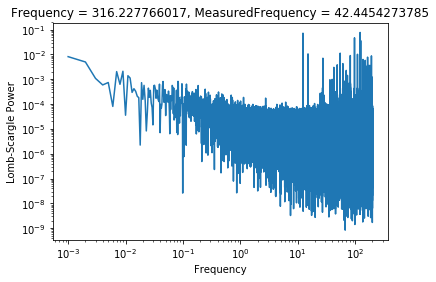

Process PoolWorker-16:
Process PoolWorker-20:
Process PoolWorker-19:
Traceback (most recent call last):
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
    self._target(*self._args, **self._kwargs)
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/mj1e16

In [ ]:
noObs = 100000

obs = np.linspace(59630.320217,59630.320217+(365.25*10),noObs)
obs = obs.tolist()
obs = [obs]*7

results = []
fullmeasuredPeriod = []
fullPeriod = []
fullPower = []
fullSigLevel = []
fullMag = []
MagRangearray = np.linspace(17,24,maglength)
MagRange = [x for x in MagRangearray]
maglist = []
for x in range(len(MagRange)):
    maglist.append([MagRange[x]]*7)

#newlist = np.linspace(59630,(10*365),10000)
#newlist = newlist.tolist()
#newlist = [newlist]*7
#print(len(newlist))
newlist = Magnitudes.mag630

print(len(longflare))
FrangeLoop = FrangeLoop[0:3]
#lombScargle(FrangeLoop[0],objectmag=newlist[0])

pool = Pool(processors)
for h in range(startnumber,endnumber):
    #print(newlist[h])
    results.append(pool.map(partial(lombScargle, objectmag=newlist[h],graphtitle=str(noObs)),FrangeLoop))
    
    twoDlist = [[],[],[],[],[],[]]
    for X in range(len(results)):
        for Y in range(len(results[X])):
            twoDlist[0].append(results[X][Y][0])
            twoDlist[1].append(results[X][Y][1])
            twoDlist[2].append(results[X][Y][2])
            twoDlist[3].append(results[X][Y][3])
            twoDlist[4].append(results[X][Y][4])
            twoDlist[5].append(results[X][Y][5])
    with open(inFile, 'r') as istr:
        with open(outFile,'w') as ostr:
            for i, line in enumerate(istr):
                # Get rid of the trailing newline (if any).
                line = line.rstrip('\n')
                if i % 2 != 0:
                    line += str(twoDlist[int((i-1)/2)])+','
                ostr.write(line+'\n')


11594880
(0.56234132519034907, (0.012, 120))
Finding optimal frequency:
 - Estimated peak width = 0.00172
 - Using 5 steps per peak; omega_step = 0.000344
 - User-specified period range:  0.012 to 1.2e+02
 - Computing periods at 1521724 steps
(0.042169650342858224, (0.012, 120))
 - Computing periods at 1521724 steps
Finding optimal frequency:
 - Estimated peak width = 0.00172
 - Using 5 steps per peak; omega_step = 0.000344
 - User-specified period range:  0.012 to 1.2e+02
(0.0031622776601683798, (0.012, 120))
Finding optimal frequency:
 - Estimated peak width = 0.00172
 - Using 5 steps per peak; omega_step = 0.000344
 - User-specified period range:  0.012 to 1.2e+02
 - Computing periods at 1521724 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


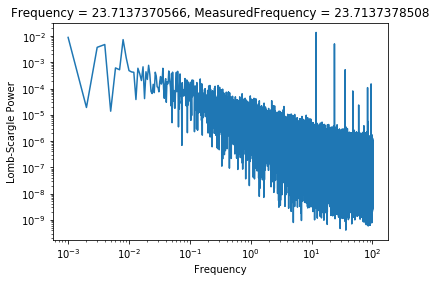

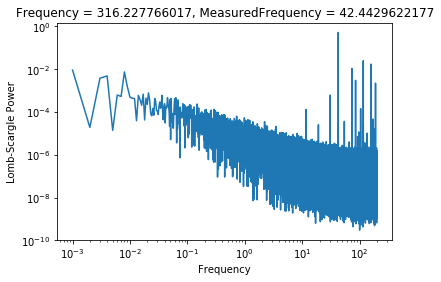

Process PoolWorker-11:
Process PoolWorker-12:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process PoolWorker-16:
    self.run()
Process PoolWorker-15:
Process PoolWorker-14:
    self.run()
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    

In [ ]:
noObs = 1000000 

obs = np.linspace(59630.320217,59630.320217+(365.25*10),noObs)
obs = obs.tolist()
obs = [obs]*7

results = []
fullmeasuredPeriod = []
fullPeriod = []
fullPower = []
fullSigLevel = []
fullMag = []
MagRangearray = np.linspace(17,24,maglength)
MagRange = [x for x in MagRangearray]
maglist = []
for x in range(len(MagRange)):
    maglist.append([MagRange[x]]*7)

#newlist = np.linspace(59630,(10*365),10000)
#newlist = newlist.tolist()
#newlist = [newlist]*7
#print(len(newlist))
newlist = Magnitudes.mag630

print(len(longflare))
FrangeLoop = FrangeLoop[0:3]
#lombScargle(FrangeLoop[0],objectmag=newlist[0])

pool = Pool(processors)
for h in range(startnumber,endnumber):
    #print(newlist[h])
    results.append(pool.map(partial(lombScargle, objectmag=newlist[h],graphtitle=str(noObs)),FrangeLoop))
    
    twoDlist = [[],[],[],[],[],[]]
    for X in range(len(results)):
        for Y in range(len(results[X])):
            twoDlist[0].append(results[X][Y][0])
            twoDlist[1].append(results[X][Y][1])
            twoDlist[2].append(results[X][Y][2])
            twoDlist[3].append(results[X][Y][3])
            twoDlist[4].append(results[X][Y][4])
            twoDlist[5].append(results[X][Y][5])
    with open(inFile, 'r') as istr:
        with open(outFile,'w') as ostr:
            for i, line in enumerate(istr):
                # Get rid of the trailing newline (if any).
                line = line.rstrip('\n')
                if i % 2 != 0:
                    line += str(twoDlist[int((i-1)/2)])+','
                ostr.write(line+'\n')


In [ ]:
noObs = 10000000

obs = np.linspace(59630.320217,59630.320217+(365.25*10),noObs)
obs = obs.tolist()
obs = [obs]*7

results = []
fullmeasuredPeriod = []
fullPeriod = []
fullPower = []
fullSigLevel = []
fullMag = []
MagRangearray = np.linspace(17,24,maglength)
MagRange = [x for x in MagRangearray]
maglist = []
for x in range(len(MagRange)):
    maglist.append([MagRange[x]]*7)

#newlist = np.linspace(59630,(10*365),10000)
#newlist = newlist.tolist()
#newlist = [newlist]*7
#print(len(newlist))
newlist = Magnitudes.mag630

print(len(longflare))
FrangeLoop = FrangeLoop[0:3]
#lombScargle(FrangeLoop[0],objectmag=newlist[0])

pool = Pool(processors)
for h in range(startnumber,endnumber):
    #print(newlist[h])
    results.append(pool.map(partial(lombScargle, objectmag=newlist[h],graphtitle=str(noObs)),FrangeLoop))
    
    twoDlist = [[],[],[],[],[],[]]
    for X in range(len(results)):
        for Y in range(len(results[X])):
            twoDlist[0].append(results[X][Y][0])
            twoDlist[1].append(results[X][Y][1])
            twoDlist[2].append(results[X][Y][2])
            twoDlist[3].append(results[X][Y][3])
            twoDlist[4].append(results[X][Y][4])
            twoDlist[5].append(results[X][Y][5])
    with open(inFile, 'r') as istr:
        with open(outFile,'w') as ostr:
            for i, line in enumerate(istr):
                # Get rid of the trailing newline (if any).
                line = line.rstrip('\n')
                if i % 2 != 0:
                    line += str(twoDlist[int((i-1)/2)])+','
                ostr.write(line+'\n')


In [ ]:
noObs = 'astro'

obs = Observations.obsastro630

results = []
fullmeasuredPeriod = []
fullPeriod = []
fullPower = []
fullSigLevel = []
fullMag = []
MagRangearray = np.linspace(17,24,maglength)
MagRange = [x for x in MagRangearray]
maglist = []
for x in range(len(MagRange)):
    maglist.append([MagRange[x]]*7)

#newlist = np.linspace(59630,(10*365),10000)
#newlist = newlist.tolist()
#newlist = [newlist]*7
#print(len(newlist))
newlist = Magnitudes.mag630

print(len(longflare))
FrangeLoop = FrangeLoop[0:3]
#lombScargle(FrangeLoop[0],objectmag=newlist[0])

pool = Pool(processors)
for h in range(startnumber,endnumber):
    #print(newlist[h])
    results.append(pool.map(partial(lombScargle, objectmag=newlist[h],graphtitle=str(noObs)),FrangeLoop))
    
    twoDlist = [[],[],[],[],[],[]]
    for X in range(len(results)):
        for Y in range(len(results[X])):
            twoDlist[0].append(results[X][Y][0])
            twoDlist[1].append(results[X][Y][1])
            twoDlist[2].append(results[X][Y][2])
            twoDlist[3].append(results[X][Y][3])
            twoDlist[4].append(results[X][Y][4])
            twoDlist[5].append(results[X][Y][5])
    with open(inFile, 'r') as istr:
        with open(outFile,'w') as ostr:
            for i, line in enumerate(istr):
                # Get rid of the trailing newline (if any).
                line = line.rstrip('\n')
                if i % 2 != 0:
                    line += str(twoDlist[int((i-1)/2)])+','
                ostr.write(line+'\n')


11594880
(0.56234132519034907, (0.5, 10))
Finding optimal frequency:
 - Estimated peak width = 0.00172
 - Using 5 steps per peak; omega_step = 0.000344
 - User-specified period range:  0.5 to 10
 - Computing periods at 34700 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
(0.042169650342858224, (0.01, 0.5))
Finding optimal frequency:
 - Estimated peak width = 0.00172
 - Using 5 steps per peak; omega_step = 0.000344
 - User-specified period range:  0.01 to 0.5
 - Computing periods at 1789727 steps
(0.0031622776601683798, (0.0029, 0.012))
Finding optimal frequency:
 - Estimated peak width = 0.00172
 - Using 5 steps per peak; omega_step = 0.000344
 - User-specified period range:  0.0029 to 0.012
 - Computing periods at 4775540 steps


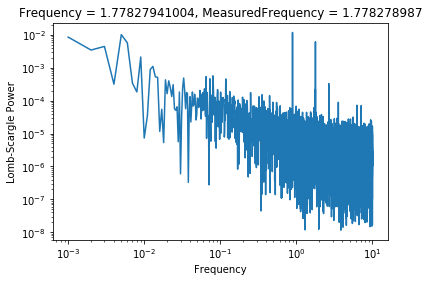

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


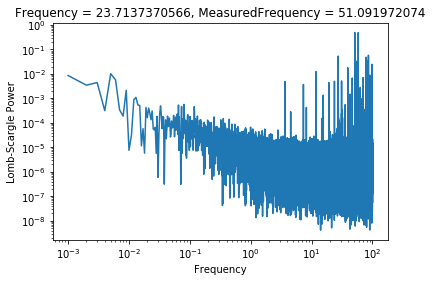

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


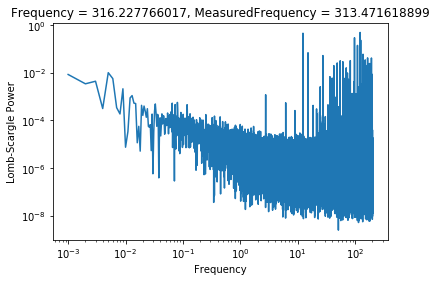

In [10]:
results = []
fullmeasuredPeriod = []
fullPeriod = []
fullPower = []
fullSigLevel = []
fullMag = []
MagRangearray = np.linspace(17,24,maglength)
MagRange = [x for x in MagRangearray]
maglist = []
for x in range(len(MagRange)):
    maglist.append([MagRange[x]]*7)

#newlist = np.linspace(59630,(10*365),10000)
#newlist = newlist.tolist()
#newlist = [newlist]*7
#print(len(newlist))
newlist = Magnitudes.mag630

print(len(longflare))
FrangeLoop = FrangeLoop[0:3]
#lombScargle(FrangeLoop[0],objectmag=newlist[0])

pool = Pool(processors)
for h in range(startnumber,endnumber):
    #print(newlist[h])
    results.append(pool.map(partial(lombScargle, objectmag=newlist[h]),FrangeLoop))
    
    twoDlist = [[],[],[],[],[],[]]
    for X in range(len(results)):
        for Y in range(len(results[X])):
            twoDlist[0].append(results[X][Y][0])
            twoDlist[1].append(results[X][Y][1])
            twoDlist[2].append(results[X][Y][2])
            twoDlist[3].append(results[X][Y][3])
            twoDlist[4].append(results[X][Y][4])
            twoDlist[5].append(results[X][Y][5])
    with open(inFile, 'r') as istr:
        with open(outFile,'w') as ostr:
            for i, line in enumerate(istr):
                # Get rid of the trailing newline (if any).
                line = line.rstrip('\n')
                if i % 2 != 0:
                    line += str(twoDlist[int((i-1)/2)])+','
                ostr.write(line+'\n')


Finding optimal frequency:
 - Estimated peak width = 0.00172
 - Using 5 steps per peak; omega_step = 0.000344
 - User-specified period range:  0.5 to 10
 - Computing periods at 34700 steps
Finding optimal frequency:
 - Estimated peak width = 0.00172
 - Using 5 steps per peak; omega_step = 0.000344
 - User-specified period range:  10 to 1.1e+02
 - Computing periods at 1662 steps
Finding optimal frequency:
 - Estimated peak width = 0.00172
 - Using 5 steps per peak; omega_step = 0.000344
 - User-specified period range:  0.5 to 10
 - Computing periods at 34700 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


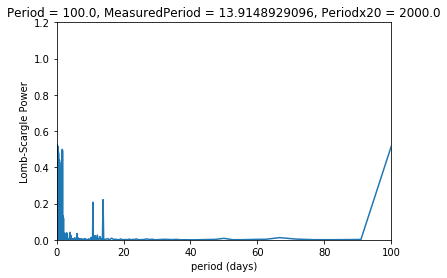

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


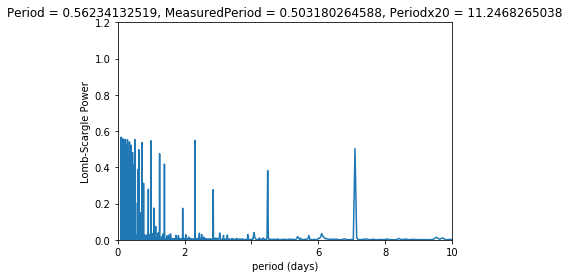

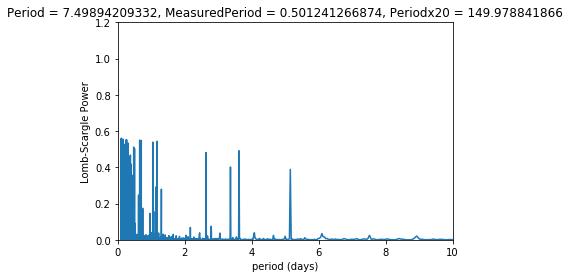

Finding optimal frequency:
 - Estimated peak width = 0.00172
 - Using 5 steps per peak; omega_step = 0.000344
 - User-specified period range:  0.01 to 0.5
 - Computing periods at 1789727 steps
Finding optimal frequency:
 - Estimated peak width = 0.00172
 - Using 5 steps per peak; omega_step = 0.000344
 - User-specified period range:  0.0029 to 0.012
 - Computing periods at 4775540 steps


  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-23:
Process ForkPoolWorker-22:
Traceback (most recent call last):
Process ForkPoolWorker-24:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  Fil

KeyboardInterrupt: 

KeyboardInterrupt
Process ForkPoolWorker-21:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-7-af099439312a>", line 78, in lombScargle
    LSperiod = model.best_period
  File "/home/mj1e16/iridisPeriodicNew/modeler.py", line 152, in best_period
    self._best_period = self._calc_best_period()
  File "/home/mj1e16/iridisPeriodicNew/modeler.py", line 162, in _calc_best_period
    return self.optimizer.best_period(self)
  File "/home/mj1e16/iridisPeriodicNew/optimizer.py", line 14, in best_period
    return_scores=False)
  File "/home/mj1e16/iridisPeriodicNew

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/mj1e16/iridisPeriodicNew/lomb_scargle_fast.py:324: RuntimeWarning: divide by zero encountered in true_divide
  power = (YC * YC / CC + YS * YS / SS) / YY
/home/mj1e16/iridisPeriodicNew/lomb_scargle_fast.py:324: RuntimeWarning: divide by zero encountered in true_divide
  power = (YC * YC / CC + YS * YS / SS) / YY
/home/mj1e16/iridisPeriodicNew/lomb_scargle_fast.py:324: RuntimeWarning: divide by zero encountered in true_divide
  power = (YC * YC / CC + YS * YS / SS) / YY
/home/mj1e16/iridisPeriodicNew/lomb_scargle_fast.py:324: RuntimeWarning: divide by zero encountered in true_divide
  power = (YC * YC / CC + YS * YS / SS) / YY


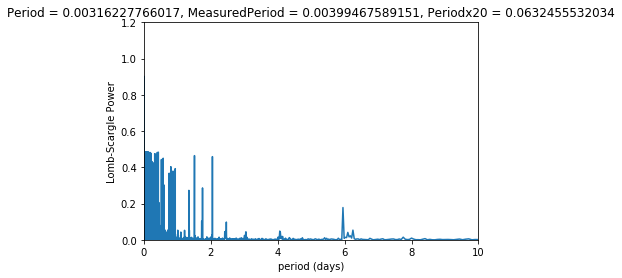

Process ForkPoolWorker-20:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


In [12]:
obs = np.linspace(59630.320217,59630.320217+(365.25*10),300)
obs = obs.tolist()
obs = [obs]*7
#In[19]:

results = []
fullmeasuredPeriod = []
fullPeriod = []
fullPower = []
fullSigLevel = []
fullMag = []
MagRangearray = np.linspace(17,24,maglength)
MagRange = [x for x in MagRangearray]
maglist = []
for x in range(len(MagRange)):
    maglist.append([MagRange[x]]*7)

#newlist = np.linspace(59630,(10*365),10000)
#newlist = newlist.tolist()
#newlist = [newlist]*7
#print(len(newlist))
newlist = Magnitudes.mag630

#lombScargle(FrangeLoop[0],objectmag=newlist[0])

pool = Pool(processors)
for h in range(startnumber,endnumber):
    #print(newlist[h])
    results.append(pool.map(partial(lombScargle, objectmag=newlist[h]),FrangeLoop))
    
    twoDlist = [[],[],[],[],[],[]]
    for X in range(len(results)):
        for Y in range(len(results[X])):
            twoDlist[0].append(results[X][Y][0])
            twoDlist[1].append(results[X][Y][1])
            twoDlist[2].append(results[X][Y][2])
            twoDlist[3].append(results[X][Y][3])
            twoDlist[4].append(results[X][Y][4])
            twoDlist[5].append(results[X][Y][5])
    with open(inFile, 'r') as istr:
        with open(outFile,'w') as ostr:
            for i, line in enumerate(istr):
                # Get rid of the trailing newline (if any).
                line = line.rstrip('\n')
                if i % 2 != 0:
                    line += str(twoDlist[int((i-1)/2)])+','
                ostr.write(line+'\n')


In [12]:
obs = np.linspace(59630.320217,59630.320217+(365.25*10),300)
obs = obs.tolist()
obs = [obs]*7
#In[19]:

results = []
fullmeasuredPeriod = []
fullPeriod = []
fullPower = []
fullSigLevel = []
fullMag = []
MagRangearray = np.linspace(17,24,maglength)
MagRange = [x for x in MagRangearray]
maglist = []
for x in range(len(MagRange)):
    maglist.append([MagRange[x]]*7)

#newlist = np.linspace(59630,(10*365),10000)
#newlist = newlist.tolist()
#newlist = [newlist]*7
#print(len(newlist))
newlist = Magnitudes.mag630


In [58]:
def ellipsoidalFlux(observations,Frequency,exptime):
    period = 1/(Frequency)
    #print(period)
    phase = [(x % (2*period)) for x in observations]
    b = [0.]*len(observations)
    b = np.asarray(b)
    for seconds in range(0, exptime):
        a = [np.sin((2*np.pi*(Frequency))*(x+(seconds/(3600*24)))) for x in observations] # optical modulation
        b += a
    #print(b)
    observations = np.asarray(observations)
    mag = np.sin(2*np.pi*Frequency*observations)
    plt.plot(observations,mag,'o')
    plt.show()
    c = b/exptime
    plt.plot(observations,c,'o')
    plt.show()
#     for x in range(0,len(phase)):
#         if (phase[x]+(1.5*period)) < (3*period):
#             c[x] = c[x]*(1./3.)
#         else:
#             c[x] = c[x]*(2./3.)
    return c



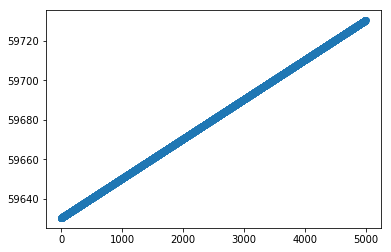

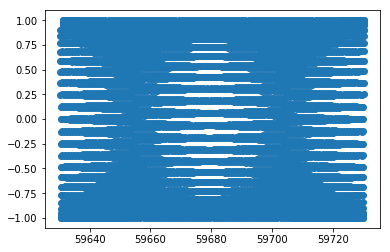

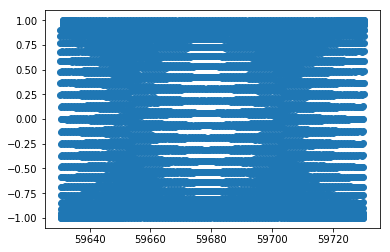

In [65]:
Obs = np.linspace(59630.320217,59630.320217+(100),5000)
plt.plot(Obs,'o')
plt.show()
frequency = 1
ellipsoidal = ellipsoidalFlux(Obs,frequency,30)


In [39]:
b = [0,0,0]
b = np.asarray(b)
for x in range(10):
    b += a
    print(b[0])
print(b)
    #c = [1,2,3]
    #d= [0.5,0.7,0.8]


1
2
3
4
5
6
7
8
9
10
[10 20 30]


In [45]:
def graphMaker(Obs,frequency,mag):
    
#     ellipsoidal = [[]]*len(obs)
#     ellipNorm = [[]]*len(obs)
    modulationAmplitude = 0.1
    #for y in range(len(Obs)):
    ellipsoidal = ellipsoidalFlux(Obs,frequency,30)

    ellipNorm = [modulationAmplitude * t for t in ellipsoidal] 

    ellipNorm = [17+x for x in ellipNorm]

#    scatter = []
#     for G in range(0, len(Obs)):
#         flareMinute = int(round(((Obs[G]-Obs[0])*24*60)))
#         if flareMinute == len(longflare):
#             flareMinute += -1
                    
                
#         scatter.append(longflare[flareMinute])
        
#         #ellipNorm[G] += longflare[flareMinute]
#     #print(scatter)    
    #plt.plot(Obs,ellipNorm,'o')
    plt.title('Light Curve: Period = '+str(1/frequency))
    plt.xlabel('Time (days)')
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()
    plt.show()
#     print(np.mean(scatter))
#     print(np.std(scatter))
#     plt.plot(Obs,ellipNorm)
#     plt.title('Light Curve: Period = '+str(1/frequency))
#     plt.xlim([Obs[30],Obs[45]])
#     plt.xlabel('Time (days)')
#     plt.ylabel('Magnitude')
#     plt.gca().invert_yaxis()
#     plt.show()

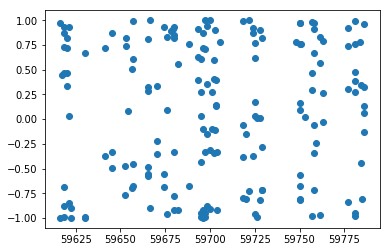

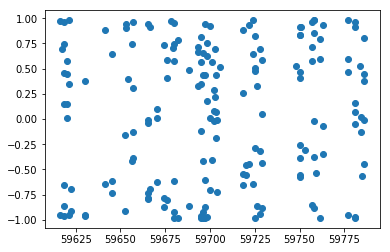

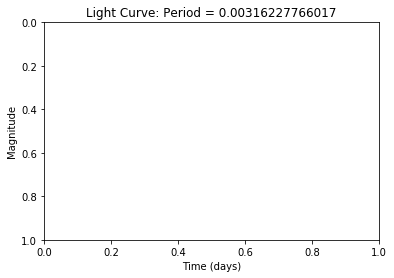

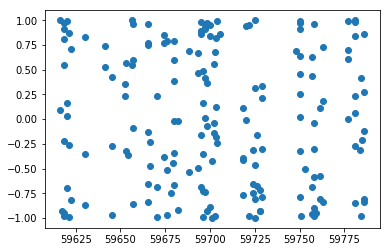

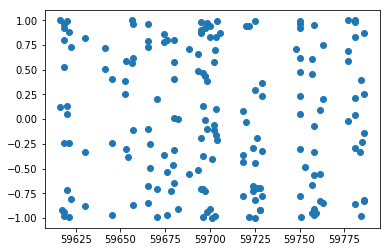

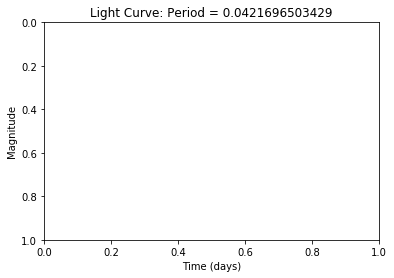

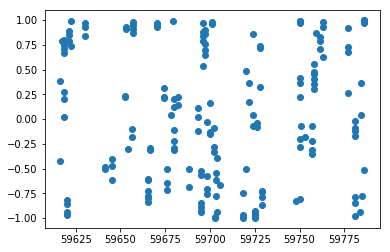

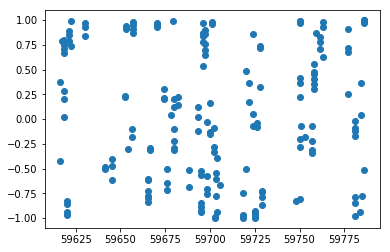

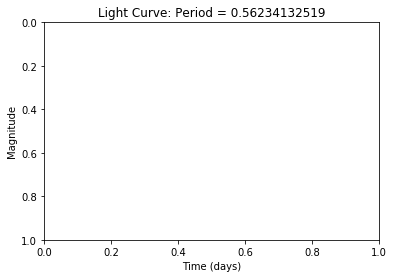

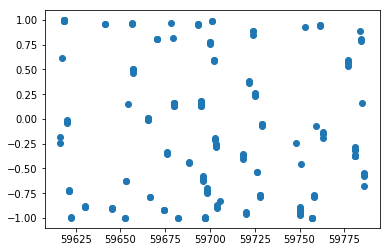

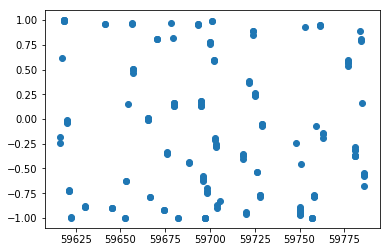

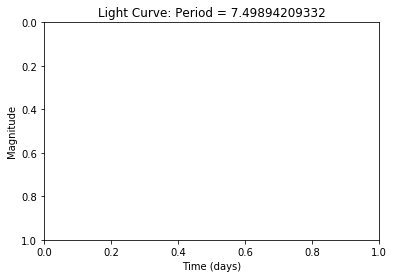

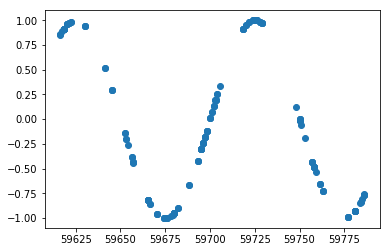

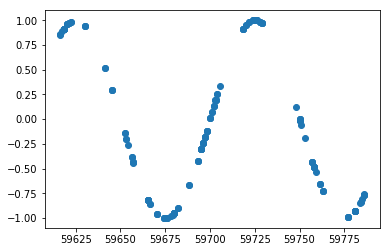

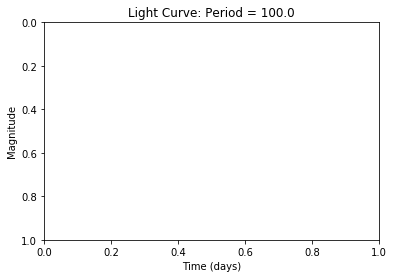

In [67]:
#obs = np.linspace(59630.320217,59630.320217+(365.25*10),1000)
obs = Observations.obsminion630

for y in range(len(FrangeLoop)):
    graphMaker(obs[0],FrangeLoop[y],newlist[0][0])

In [67]:
(obs[0][-1]-obs[0][0])*24*60

5259600.0

In [65]:
len(longflare)

5842433